# 03) Improve labels

A key problem with the headlines data is that the keyword matching process during data collection likely missed many non-risk headlines, meaning the default non-risk category contains false negatives. To tackle this problem, a regression model for each language (Spanish and Portuguese) is trained on half of the data at a time to generate predictions for the other half's non-risk headlines. A percentage of low probability headlines from each half is kept, eliminating many false negatives and tackling the class imbalance problem (see notebook 1). 

## Read-in data

Seperate dataframes are created for each language (Spanish & Portuguese). 

In [1]:
import pandas as pd
import numpy as np

# read-in data
df = pd.read_csv('../Data/original_headlines.csv', encoding='utf-8')
print(str(round(len(df)/1000, 1)) + 'K Total headlines')

# include only spanish 
spanish_df = df[df.country.isin(['Argentina', 'Colombia', 'Mexico'])].reset_index(drop=True)
print(str(round(len(spanish_df)/1000, 1)) + 'K Spanish headlines')

# include only portuguese 
portuguese_df = df[df.country == 'Brazil'].reset_index(drop=True)
print(str(round(len(portuguese_df)/1000, 1)) + 'K Portuguese headlines')

85.8K Total headlines
69.3K Spanish headlines
13.9K Portuguese headlines


## Remove duplicates & thumbnails

Headlines containing the word thumbnail are normally videos which cannot be scraped. Many of these with a similar format in the non-risk headlines data add little value in terms of variety and therefore are removed.

In [2]:
# remove duplicates
spanish_df.drop_duplicates(subset='headline', inplace=True)
portuguese_df.drop_duplicates(subset='headline', inplace=True)

# remove thumbnails
spanish_df = spanish_df[~spanish_df['headline'].str.lower().str.contains('thumbnail', na=False)]
portuguese_df = portuguese_df[~portuguese_df['headline'].str.lower().str.contains('thumbnail', na=False)]

# removes english headlines from the spanish dataset
spanish_df = spanish_df.loc[~spanish_df.website.isin(['Colombia Reports'])]

# reset index
spanish_df.reset_index(drop=True, inplace=True)
portuguese_df.reset_index(drop=True, inplace=True)

## Clean text

The text is subjected to common cleaning techniques to reduce dimensionality.

In [3]:
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
spanish_stop_words = set(stopwords.words('Spanish'))
portuguese_stop_words = set(stopwords.words('Portuguese'))

# common text cleaning techniques
def clean_text(text, language):
    text = text.strip()
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '¡¿'))

    if language=='Spanish':
        text = ' '.join([word for word in text.split() if word not in spanish_stop_words])
    elif language=='Portuguese':
        text = ' '.join([word for word in text.split() if word not in portuguese_stop_words])
    
    return text

spanish_df['headline'] = [clean_text(x, 'Spanish') for x in spanish_df['headline']]
portuguese_df['headline'] = [clean_text(x, 'Portuguese') for x in portuguese_df['headline']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jack-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Put aside data

A percentage of the data from each dataframe is put aside. It is useful to this now because if not we may end up evaluating on an artificially easy dataset in which most of the more difficult edge cases for non-risk headlines have been removed. 

In [4]:
import random 

# returns the main dataframe and a random sample to be put aside for evaluation
def put_aside_random_percent(df, percent):
    indices = list(df.index)
    dividor = int(100 / percent)
    sample_size = int(np.floor(len(indices)/dividor))
    random_sample = random.sample(indices, sample_size)
    put_aside_headlines = df.iloc[random_sample,:].reset_index(drop=True)
    df = df.loc[~df.index.isin(random_sample)].reset_index(drop=True)
    return df, put_aside_headlines

spanish_df_post_sample, spanish_put_aside_df = put_aside_random_percent(spanish_df, 10)
portuguese_df_post_sample, portuguese_put_aside_df = put_aside_random_percent(portuguese_df, 10)

## Split dataframe

Each dataframe is randomly split into two sets so a model can be trained on each set and used to predict headlines for the other.

In [5]:
# randomly split a dataframe into 2 equal size groups 
def split_dataframes(df):
    population = list(range(len(df)))
    half_headlines = int(np.floor(len(population) / 2))
    random_samples = random.sample(population, half_headlines)
    return df.loc[random_samples,:].reset_index(drop=True), df.loc[~df.index.isin(random_samples), :].reset_index(drop=True)

## Fit model

A model is fit using TF-IDF vectors and logistic regression. A regression model is used to obtain probabilities so that the classification threshold can be easily varied. 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# vectorizes data and fits a model 
def fit_model(df):
    X, y = df.headline, [int(pd.notna(x)) for x in df.risk_type]
    vectorizer = TfidfVectorizer()
    train_tfidf = vectorizer.fit_transform(X)
    model = LogisticRegression()
    model.fit(train_tfidf, y)
    return vectorizer, model

## Generate predictions

Predictions from one half of each dataset are added to the other half.

In [7]:
# returns predictions as binary decisions and probabilities
def predict_headlines(df, vectorizer, model):
    tfidf_vectors = vectorizer.transform(df.headline)
    y_preds = model.predict(tfidf_vectors)
    y_pred_prob = [np.mean(model.predict_proba(x)[:, 1]) for x in tfidf_vectors]
    return y_preds, y_pred_prob

# adds the predictions for each half of the data to their respective dfs
def add_predictions_to_df(primary_df, secondary_df):
    vectorizer, model = fit_model(secondary_df)
    y_preds, y_pred_prob = predict_headlines(primary_df, vectorizer, model)
    primary_df['y_pred'], primary_df['y_pred_prob'] = y_preds, y_pred_prob
    primary_df.sort_values('y_pred_prob', ascending=False, inplace=True)
    return primary_df

# returns a headlines dataframe along with their predictions for veiwing
# this is useful so we can set appropriate upper and lower limits for the 
# slice of low probability non-risk headlines we will select later on
def view_headline_preds(df, language):
    df_1, df_2 = split_dataframes(df) 
    df_1, df_2 = add_predictions_to_df(df_1, df_2), add_predictions_to_df(df_2, df_1)
    #df_1, df_2 =  drop_non_risk_headlines(df_1, language), drop_non_risk_headlines(df_2, language)
    return df_1, df_2

spanish_df_1, spanish_df_2 = view_headline_preds(spanish_df_post_sample, 'Spanish')
portuguese_df_1, portuguese_df_2 = view_headline_preds(portuguese_df_post_sample, 'Portuguese')

## Find false negatives threshold

The threshold at which false negatives are no longer common is located and used for the upper limits in the next step.

In [8]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
def view_nonrisk_highest_rows(df, start, end):
    temp_df = df.loc[pd.isna(df.risk_type)].sort_values('y_pred_prob')
    print()
    print('Non-risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent
    
spanish_false_negative_percent = view_nonrisk_highest_rows(spanish_df_1, 7990, 8000)
portuguese_false_negative_percent = view_nonrisk_highest_rows(portuguese_df_1, 1990, 2000)


Non-risk headlines: 23819

21357:   homenaje gardel teatro tich
13612:   acceder tipo servicios usuarios deberán compartir aún información personal levantado bastantes críticas
2720:   investigan desaparición tres fusiles estación policía minca magdalena
16683:   académicos sugirieron corte revisar datos unidad 2022 2023 2024 futuros ayudaría mejorar finanzas sistema
7478:   fallecimiento pintor ansermeño
15811:   usuarios redes sociales alertado llamadas fraudulentas números extranjeros consejos
13780:   investigaciones contratos pae plato tenerife nueva granada
24414:   amaneció nuevo millonario cayó miloto bogotá números ganadores
5504:   propina obligatoria así debe ser
14484:   eduardo verano rosa reunido ministro minas andrés camacho hablar altas tarifas energía

Non-risk headlines: 4608

2328:   ação arquivada rafael cardoso paga dois salários mínimos encerrar processo agressão ameaça
4287:   cozinha quiosque guará pega fogo fica parcialmente destruída
432:   brasil pm atira ho

## Drop false negatives

All non-risk headlines above the threshold above are dropped, eliminating many false negatives and tackling the class imbalance problem (see notebook 1).

In [9]:
# drops a number of non-risk headlines based on their prediction scores
def drop_non_risk_headlines(df, percent):   
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    risk_df = df.loc[~pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(non_risk_df) * percent))
    low_score_non_risk = non_risk_df.iloc[(len(non_risk_df)-upper_limit):(len(non_risk_df)-lower_limit),:]
    return pd.concat([risk_df, low_score_non_risk])

# creates a filtered dataframe combining both halfs of the data 
# after dropping headlines with high predictions
def create_filtered_df(df_1, df_2, percent):
    df_1, df_2 =  drop_non_risk_headlines(df_1, percent), drop_non_risk_headlines(df_2, percent)
    return pd.concat([df_1, df_2])

false_negatives_filtered_spanish_df = create_filtered_df(spanish_df_1, spanish_df_2, spanish_false_negative_percent)
false_negatives_filtered_portuguese_df = create_filtered_df(portuguese_df_1, portuguese_df_2, portuguese_false_negative_percent)

## Find false positives threshold

In [10]:
# this function shows the risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false positives in the data...
def view_risk_lowest_rows(df, start, end):
    temp_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob').reset_index(drop=True)
    print()
    print('Risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent
    
spanish_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_spanish_df, 50, 60)
portuguese_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_portuguese_df, 30, 40)


Risk headlines: 7358

50:   tras protestas rentarán equipo mitigar calor clínicas imss torreónse verán beneficiadas clínicas 71 16 imss después protestas fallas sistema aire acondicionado unidad médica alta especialidad umae 71 seguro social torreón trabajadores la…
51:   procedimiento concedió amparo mauricio toledo extradición repondrá
52:   fotomultas exceso velocidad paso paso apelarlas
53:   luego sendos editoriales pilón radio guatapurí quejas ciudadanía supuestos malos procedimientos momento hacer comparendos tránsito base fotomultas tema picó extendió
54:   generado mucha expectativa anuncio través líneas hizo administración municipal relacionado contratación consultoría explorar todas opciones permitan volver parque leyenda vallenata centro actividad cultural permanente 365 días año
55:   golpes disputan sindicato imss
56:   dolor cabeza viajeros cierres línea tomar ruta larga
57:   promueven amparo pésimas condiciones carretera federal 180 ciudad carmen
58:   claudia sheinba

## Drop false positives

In [11]:
# drops a number of risk headlines based on their prediction scores
def drop_risk_headlines(df, percent):   
    risk_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob')
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(risk_df) * percent))
    high_score_risk = risk_df.iloc[upper_limit:len(risk_df),:]
    combined_df = pd.concat([high_score_risk, non_risk_df])
    return combined_df.reset_index(drop=True)

false_positives_filtered_spanish_df = drop_risk_headlines(false_negatives_filtered_spanish_df, spanish_false_positive_percent)
false_positives_filtered_portuguese_df = drop_risk_headlines(false_negatives_filtered_portuguese_df, portuguese_false_positive_percent)

## Train test split

Creates a train test split for a given dataframe.

In [12]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, test_size=0.25):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=test_size, stratify=y)

## Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [13]:
from sklearn.metrics import classification_report, accuracy_score

# evaluates the model's performance and prints the results
def evaluate_model(model, X_test_tfidf, y_test):
    y_pred = model.predict(X_test_tfidf)
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1] 
    classification_report_ = classification_report(y_test, y_pred)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print("Classification Report:\n", classification_report_)
    print()
    return classification_report(y_test, y_pred, output_dict=True)

## Check results

A model is trained on the filtered dataset and evaluated on the set aside data. As we can see, the recall for risk headlines (the main business objective of this project) has improved dramatically for both languages (see notebook 2). 

In [14]:
# evaluates a filtered dataset against new headlines
def check_results(train_df, put_aside_df, language):
    print()
    print('*** ' + language + ' ***')
    print()

    X_train, X_test, y_train, y_test = split_data(train_df, test_size=0.01)
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    print(str(round(len(put_aside_df)/1000, 2)) + 'K put aside headlines')
    
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)
    y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]
    return evaluate_model(model, y_test, y_test)

## Original labels 

Evaluates the results of using the original labels.

In [15]:
# trains and evaluates a model on the unfiltered data
unfiltered_spanish_classification_report_ = check_results(spanish_df, spanish_put_aside_df, language='Spanish')
unfiltered_portuguese_classification_report_ = check_results(portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

6.11K put aside headlines
Accuracy: 0.936
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5310
           1       0.89      0.58      0.70       799

    accuracy                           0.94      6109
   macro avg       0.91      0.79      0.83      6109
weighted avg       0.93      0.94      0.93      6109



*** Portuguese ***

1.32K put aside headlines
Accuracy: 0.881
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93      1011
           1       0.93      0.54      0.68       312

    accuracy                           0.88      1323
   macro avg       0.90      0.76      0.80      1323
weighted avg       0.89      0.88      0.87      1323




## Improved labels

Evaluates the results of using the improved labels.

In [16]:
# trains and evaluates a model on the filtered data
filtered_spanish_classification_report_ = check_results(false_positives_filtered_spanish_df, spanish_put_aside_df, language='Spanish')
filtered_portuguese_classification_report_ = check_results(false_positives_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

6.11K put aside headlines
Accuracy: 0.821
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      5310
           1       0.41      0.88      0.56       799

    accuracy                           0.82      6109
   macro avg       0.70      0.85      0.73      6109
weighted avg       0.90      0.82      0.84      6109



*** Portuguese ***

1.32K put aside headlines
Accuracy: 0.767
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83      1011
           1       0.50      0.82      0.62       312

    accuracy                           0.77      1323
   macro avg       0.72      0.79      0.73      1323
weighted avg       0.83      0.77      0.78      1323




## Repeat the process...

Given that the process above improved the model, it stands to reason that repeating the false negative filtering process with predictions based on the newly refined dataset could improve the model even further. The results below show that although the overall accuracy for both models declined (likely because we are dropping badly needed data), the most important metric for this project (risk headlines recall) went up in both datasets. 

### Generate new predictions

In [17]:
# resets the indices
false_positives_filtered_spanish_df.reset_index(drop=True, inplace=True)
false_positives_filtered_portuguese_df.reset_index(drop=True, inplace=True)

# creates additional dataframes with new predictions based on a model trained on the newly filtered dataframe
spanish_df_3, spanish_df_4 = view_headline_preds(false_positives_filtered_spanish_df, 'Spanish')
portuguese_df_3, portuguese_df_4 = view_headline_preds(false_positives_filtered_portuguese_df, 'Portuguese')

### Find new false negatives threshold

In [18]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
new_spanish_percent = view_nonrisk_highest_rows(spanish_df_4, 7001, 7011)
new_portuguese_percent = view_nonrisk_highest_rows(portuguese_df_4, 1681, 1691)


Non-risk headlines: 8029

8283:   activará nueva tarifa peaje papiros vía mar partir agosto
8608:   jornada quirúrgica imssbienestar sonora
8559:   encuentras gato alexa puede ayudar buscarlo
9180:   pésimo comunidad sembró árboles huecos vía bogotámedellín
10093:   evade corral audiencia envía abogado
5170:   maría corina machado edmundo gonzález
7728:   senadores morena integrarán agenda revisión acciones alcalde torreón 1241
7777:   accidentes carreteros cuestan 58 mmdp
8387:   pgn verificará rutas atención niñas embera sido abusadas
5923:   destinarán 70 millones pesos infraestructura física educativapara ejercicio 2024 cuenta presupuesto alrededor 70 millones pesos invertirlos infraestructura física educativa comarca lagunera durango ejercicio 2024 cuenta presupuesto alrededor 70 millones pesos invertirlos infraestructura física educativa comarca lagunera durango…

Non-risk headlines: 1997

2418:   acidenteao vivo ônibus atropela ciclista rodovia sol anchieta segundo motorista ôn

### Drop headlines and evaluate new results

In [19]:
# create new filtered dfs with fewer non-risk headlines
new_filtered_spanish_df = create_filtered_df(spanish_df_3, spanish_df_4, new_spanish_percent)
new_filtered_portuguese_df = create_filtered_df(portuguese_df_3, portuguese_df_4, new_portuguese_percent)

# evaluates the results
filtered_spanish_classification_report_ = check_results(new_filtered_spanish_df, spanish_put_aside_df, language='Spanish')
filtered_portuguese_classification_report_ = check_results(new_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

6.11K put aside headlines
Accuracy: 0.758
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      5310
           1       0.34      0.90      0.49       799

    accuracy                           0.76      6109
   macro avg       0.66      0.82      0.67      6109
weighted avg       0.90      0.76      0.80      6109



*** Portuguese ***

1.32K put aside headlines
Accuracy: 0.714
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.66      0.78      1011
           1       0.45      0.88      0.59       312

    accuracy                           0.71      1323
   macro avg       0.70      0.77      0.69      1323
weighted avg       0.83      0.71      0.74      1323




## Visualize results

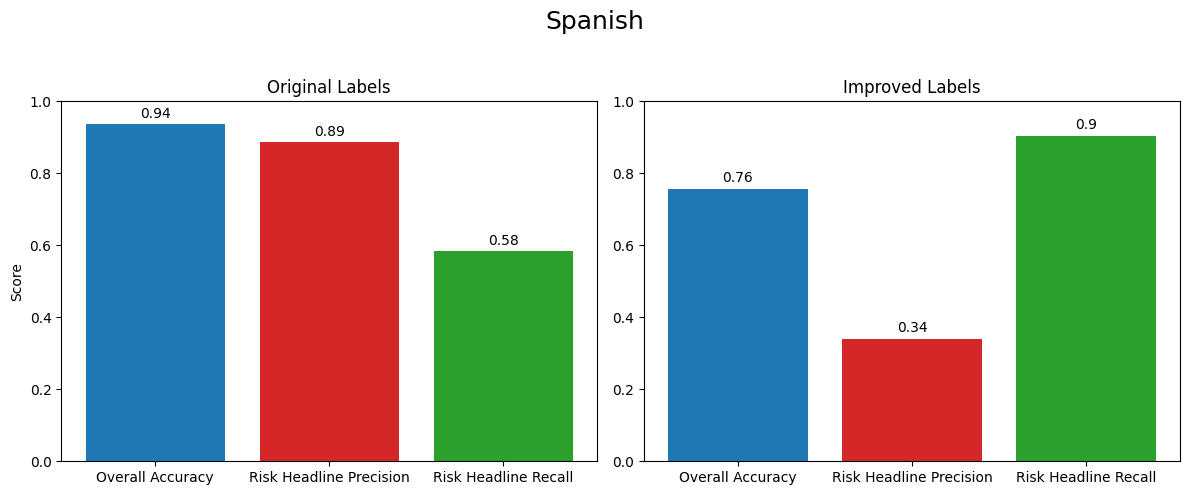

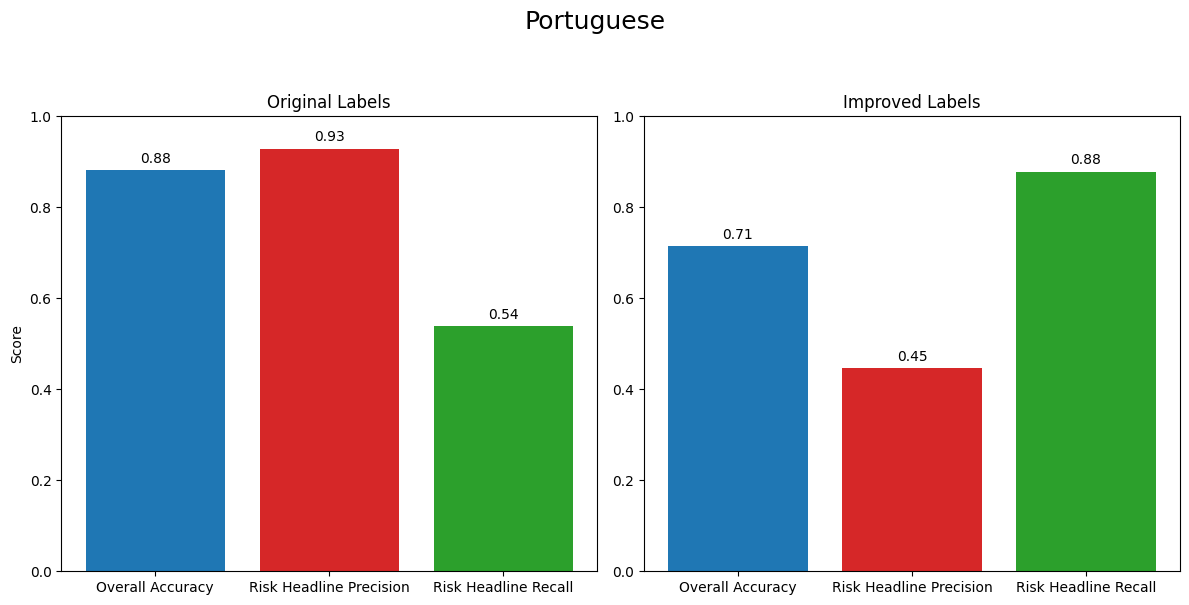

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# data
base_model_spanish = [
    unfiltered_spanish_classification_report_['accuracy'],
    unfiltered_spanish_classification_report_['1']['precision'],
    unfiltered_spanish_classification_report_['1']['recall']
]
new_model_spanish = [
    filtered_spanish_classification_report_['accuracy'],
    filtered_spanish_classification_report_['1']['precision'],
    filtered_spanish_classification_report_['1']['recall']
]
base_model_portuguese = [
    unfiltered_portuguese_classification_report_['accuracy'],
    unfiltered_portuguese_classification_report_['1']['precision'],
    unfiltered_portuguese_classification_report_['1']['recall']
]
new_model_portuguese = [
    filtered_portuguese_classification_report_['accuracy'],
    filtered_portuguese_classification_report_['1']['precision'],
    filtered_portuguese_classification_report_['1']['recall']
]

# labels for the statistics
labels = ['Overall Accuracy', 'Risk Headline Precision', 'Risk Headline Recall']
colors = ['tab:blue', 'tab:red', 'tab:green']

# create subplots for Spanish
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot baseline model stats for Spanish
bars = axs[0].bar(labels, base_model_spanish, color=colors)
axs[0].set_title('Original Labels')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot new model stats for Spanish
bars = axs[1].bar(labels, new_model_spanish, color=colors)
axs[1].set_title('Improved Labels')
axs[1].set_ylim(0, 1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title for Spanish
fig.suptitle('Spanish', fontsize=18)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_spanish_metrics.png', dpi=600, bbox_inches='tight')

# show the Spanish plot
plt.show()

# create subplots for Portuguese
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot baseline model stats for Portuguese
bars = axs[0].bar(labels, base_model_portuguese, color=colors)
axs[0].set_title('Original Labels')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot new model stats for Portuguese
bars = axs[1].bar(labels, new_model_portuguese, color=colors)
axs[1].set_title('Improved Labels')
axs[1].set_ylim(0, 1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title for Portuguese
fig.suptitle('Portuguese', fontsize=18, y=1)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_portuguese_metrics.png', dpi=600, bbox_inches='tight')

# show the Portuguese plot
plt.show()

## Save dataframes

Finally, the refined dataframes are saved as CSV files for further use in additional notebooks.

In [21]:
# put aside data (for evaluation in other notebooks)
spanish_put_aside_df.to_csv('../Data/spanish_put_aside_df.csv', index=False)
portuguese_put_aside_df.to_csv('../Data/portuguese_put_aside_df.csv', index=False)

# filtered dataframes (for use in further training)
new_filtered_spanish_df.to_csv('../Data/spanish_df.csv', index=False)
new_filtered_portuguese_df.to_csv('../Data/portuguese_df.csv', index=False)